# Q-Learning

This notebook implements the Q-Learning algorithm for the [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/) game.
See `../ReinforcementLearning_Guide.md` for theory and intuition.

According to the OpenAI environment page of FrozenLake: "The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile."

The surface is described using a grid:

    SFFF       (S: starting point, safe)
    FHFH       (F: frozen surface, safe)
    FFFH       (H: hole, fall to your doom)
    HFFG       (G: goal, where the frisbee is located)

The game episode ends when the agent reaches the goal or it falls in a hole. You receive a reward of 1 if you reach the goal, zero otherwise.

We are going to disable the slippery property; otherwise taken actions are not carried out necessarily, and the learning process takes longer. That change is after this post:

[https://github.com/openai/gym/issues/565](https://github.com/openai/gym/issues/565)

Overview of sections:

1. Basic setup of FrozenLake
2. Q-Learning Table Initialization & Hyperparameters
3. Q-Learning Table Update Functions
4. Training Loop
5. Utilization and Visualization

## 1. Basic setup of FrozenLake

In [22]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib notebook

In [23]:
import gym

In [24]:
# In order to remove the slippery tiles, we need to create/register a new environment
# with custom properties.
# That can be done as explained on this link
# https://github.com/openai/gym/issues/565
from gym.envs.registration import register
try:
    register(
        id='FrozenLakeNotSlippery-v0', # our custom name
        entry_point='gym.envs.toy_text:FrozenLakeEnv', # take the FrozenLakeEnv as the template
        kwargs={'map_name' : '4x4', 'is_slippery': False}, # changes we apply; look at Github
        max_episode_steps=100, # default 100; 100 steps allowed in an episode
        # the reward_threshold makes sense for games with continuous rewards
        # such as the cart pole; but not really here
        # we leave the default, though
        reward_threshold=.8196, # optimum = .8196
    )
except:
    print('A new env can be registered only once.')

/Users/mxagar/opt/anaconda3/envs/tf/lib/python3.7/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment FrozenLakeNotSlippery-v0
  logger.warn("Overriding environment {}".format(id))


In [25]:
# We create an env and play in it
# Note that the environment is completely rendered after each step/action
env = gym.make('FrozenLakeNotSlippery-v0')
env.reset()

for step in range(5):
    env.render()
    action = env.action_space.sample()
    env.step(action)
    #time.sleep(0.5)
env.close()


SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG


In [93]:
# To clear/flush the text display we can use clear_output on Jupyter
from IPython.display import clear_output
# On python scripts:
# import os
# os.system('clear') # 'cls' ono Windows

In [27]:
# We create an env and play in it
env = gym.make('FrozenLakeNotSlippery-v0')
env.reset()

for step in range(10):
    env.render()
    action = env.action_space.sample()
    observation,reward,done,info = env.step(action)
    time.sleep(0.2)
    clear_output(wait=True)
    if done:
        env.reset()
env.close()

  (Up)
SFFF
FHFH
FFFH
HFFG


## 2. Q-Learning Table Initialization & Hyperparameters

In [35]:
# Q-Learning Table: columns x actions
action_size = env.action_space.n # 4
# Observation = State in this game!
state_size = env.observation_space.n # 4*4

In [38]:
# It is also common practice to initialize it with small and random values
# but we leave it to 0s
q_table = np.zeros([state_size,action_size])

In [46]:
q_table.shape

(16, 4)

In [47]:
q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

### Hyperparameters

Usually we get initial value estimate by reading papers. The most important hyperparameters we need to choose:
- Alpha: learning rate; if we set it too low it is going to take vey long to converge, if too high, it's not going to learn
- Gamma: Discount factor; factor multiplied to the future rewards (gamma^2 + gamma^3 + ...), it should be close to 1
- Epochs = Episodes: how many times the agent plays the game, i.e. (hit done)
- Epsilon: usually is set to 1 (complete exploration) and a decay function is defined. The decay function can be of many forms, we choose an exponential decay

In [41]:
EPOCHS = 20000

In [42]:
ALPHA = 0.8

In [43]:
GAMMA = 0.95

In [80]:
EPSILON = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.001

## 3. Q-Learning Table Update

The Q-Learning update equation is

$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha[R_{t+1} + \gamma \max_a{Q(S_{t+1},a)} - Q(S_t,A_t)]$

Note that the term related to the action selection with the highest Q value is $\max_a{Q(S_{t+1},a)}$.
To find the balance between **exploration** (random action) vs **exploitation** (best known action = the action with the highest Q) we need to act on this term.
For that, we use **epsilon greedy selection**: we choose a random action (exploration) depending on the epsilon value; since epsilon decays, we are going to choose less random actions with time.

In summary, we need to program these steps/functions:
- Epsilon greedy action selection
- Q-Learning update equation
- Epsilon (exponential) decay after each epoch/episode

In [81]:
# Epsilon greedy action selection
def epsilon_greedy_action_selection(epsilon,q_table,discrete_state):
    random_number = np.random.random()
    # Exploitation: choose action that maximizes Q
    if random_number > epsilon:
        # Grab state action row, with all Q values
        state_row = q_table[discrete_state,:]
        # Select the action index which has the largest Q value
        action = np.argmax(state_row)
    # Exploration: choose a random action
    else:
        action = env.action_space.sample()
    return action

In [82]:
# Q-Learning update equation
# Q_next = Q_old + ALPHA*Q_error
# Q_error = reward + GAMMA*Q_optimum - Q_old
def compute_next_q_value(old_q_value,reward,next_optimal_q_value):
    Q_error = reward + GAMMA*next_optimal_q_value - old_q_value
    Q_next = old_q_value + ALPHA*Q_error
    return Q_next

In [83]:
# Epsilon exponential decay after each episode/epoch
def reduce_epsilon(epsilon,epoch):
    return min_epsilon + (max_epsilon-min_epsilon)*np.exp(-decay_rate*epoch)

## 4. Training Loop

In [86]:
# List that tracks the rewards for each episode/epoch
rewards = []
log_interval = 1000
for episode in range(EPOCHS):
    state = env.reset() # at the beginning, state = 0
    done = False
    total_rewards = 0
    # Agent plays one game
    # Done is hit if (1) we reach max steps/actions, (2) G is reached, (3) H is reached
    while not done:
        # Select ACTION
        action = epsilon_greedy_action_selection(EPSILON,q_table,state)
        # Perform step
        new_state,reward,done,info = env.step(action)
        # Grab (old = current) Q value: Q(s_t,a_t)
        old_q_value = q_table[state,action]
        # Get (next) optimal Q value from the table: Q(s_t+1,a_t+1)
        next_optimal_q_value = np.max(q_table[new_state,:])
        # Compute next Q value with Q-Learning update formula
        next_q = compute_next_q_value(old_q_value,reward,next_optimal_q_value)
        # Update the table
        q_table[state,action] = next_q
        # Track rewards
        total_rewards = total_rewards + reward
        # Update state for next loop
        state = new_state
    # Reduce epsilon
    EPSILON = reduce_epsilon(EPSILON,episode+1)
    # Track rewards
    rewards.append(total_rewards)
    # Output
    if episode % log_interval == 0:
        print(f"{episode} games played; accumulated reward: {np.sum(rewards)}")
env.close()

0 games played; accumulated reward: 0.0
1000 games played; accumulated reward: 265.0
2000 games played; accumulated reward: 978.0
3000 games played; accumulated reward: 1877.0
4000 games played; accumulated reward: 2830.0
5000 games played; accumulated reward: 3802.0
6000 games played; accumulated reward: 4788.0
7000 games played; accumulated reward: 5780.0
8000 games played; accumulated reward: 6773.0
9000 games played; accumulated reward: 7760.0
10000 games played; accumulated reward: 8745.0
11000 games played; accumulated reward: 9733.0
12000 games played; accumulated reward: 10727.0
13000 games played; accumulated reward: 11719.0
14000 games played; accumulated reward: 12709.0
15000 games played; accumulated reward: 13704.0
16000 games played; accumulated reward: 14694.0
17000 games played; accumulated reward: 15686.0
18000 games played; accumulated reward: 16680.0
19000 games played; accumulated reward: 17671.0


In [88]:
# Check the final Q-Learning table
q_table

array([[3.06288288, 3.22408724, 3.22408724, 3.06288288],
       [3.06288288, 0.        , 3.39377604, 3.21151081],
       [3.2115133 , 3.57239583, 3.16184041, 3.36859507],
       [3.38873843, 0.        , 2.08398079, 2.08398079],
       [3.22408724, 3.39377604, 0.        , 3.06288288],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 3.76041667, 0.        , 3.26783101],
       [0.        , 0.        , 0.        , 0.        ],
       [3.39377604, 0.        , 3.57239583, 3.22408724],
       [3.39377604, 3.76041667, 3.76041667, 0.        ],
       [3.57239583, 3.95833333, 0.        , 3.57239583],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 3.76041667, 3.95833333, 3.57239583],
       [3.76041667, 3.95833333, 4.16666667, 3.76041667],
       [0.        , 0.        , 3.33333333, 0.        ]])

**IMPORTANT persona interpretation**: Note that eventhough the reward is 1 only when we hit the G cell (i.e., close to the state 15), the Q values increase for all other states, including the ones with low values (the initial cells). That Q value propagation occurs due to the following fact: the reward and the next Q refer to the next state, but the current Q value is updated with them; thus, we can intuitively see how the Q value increases are propagated from the goal state back to the initial states.

## 5. Utilization and Visualization

### Utilization

After training has concluded, we can use the `q_table` to take the best action given the state we are in, thus, reaching the goal the fastest possible.

In [89]:
state = env.reset()
for steps in range(100):
    env.render()
    action = np.argmax(q_table[state,:])
    state,reward,done,info = env.step(action)
    time.sleep(1)
    clear_output(wait=True)
    if done:
        break
env.close()

  (Right)
SFFF
FHFH
FFFH
HFFG


### Training Visualization

We could visualize the training process with matplotlib. For that, we initialize the `q_table` and copy & paste the training loops for some modifications.

**Note 1**: The instructor plotted an interactive diagram, but that does not work out-of-the-box in Jupyter Lab, only in Jupyter Notebooks. A solution is to follow what is said in this link:

[https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab](https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab)

Or, alternative, we ca just use the following magic command and just plot the final diagram:

```
%matplotlib inline
```

**Note 2**: See how the rewards become linear with the time (=epochs). That is what we wanted to achieve: the agent basically wins every game at the end and the rewards add up in proportio to the games played!

In [95]:
q_table = np.zeros([state_size,action_size])

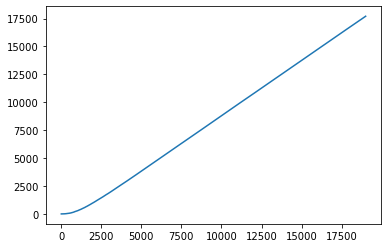

In [96]:
%matplotlib inline
# Same training loop as before, but with some plotting procedures
rewards = []
log_interval = 1000
####################################
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion() # interactive mode on
fig.canvas.draw()
epoch_plot_tracker = []
total_reward_plot_tracker = []
####################################
for episode in range(EPOCHS):
    state = env.reset()
    done = False
    total_rewards = 0
    while not done:
        action = epsilon_greedy_action_selection(EPSILON,q_table,state)
        new_state,reward,done,info = env.step(action)
        old_q_value = q_table[state,action]
        next_optimal_q_value = np.max(q_table[new_state,:])
        next_q = compute_next_q_value(old_q_value,reward,next_optimal_q_value)
        q_table[state,action] = next_q
        total_rewards = total_rewards + reward
        state = new_state
    EPSILON = reduce_epsilon(EPSILON,episode+1)
    rewards.append(total_rewards)
    ####################################
    total_reward_plot_tracker.append(np.sum(rewards))
    epoch_plot_tracker.append(episode)
    ####################################
    if episode % log_interval == 0:
        #print(f"{episode} games played; accumulated reward: {np.sum(rewards)}")
        ax.clear()
        ax.plot(epoch_plot_tracker,total_reward_plot_tracker)
        fig.canvas.draw()
env.close()